In [52]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Out shape X,Y is: (10000, 256, 256) (10000, 256, 256)
Show first 10 images of X:


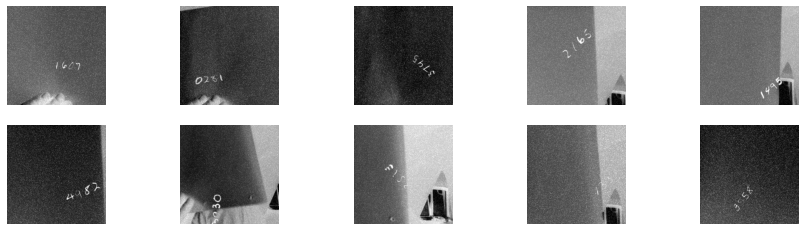

In [424]:
###Load data

x_load, y_load = dgen.Image_generator.load_data(name="base_unet_256x256_select_map_small")


###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Show first 10 images of X:")
dbug.Debug.show_images_list(x_load[:10], col_number = 5)

Show first 10 images of Y:


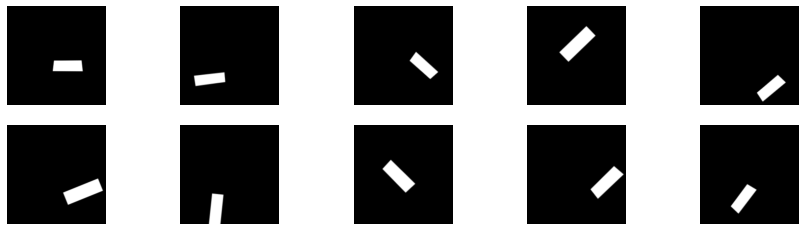

In [425]:
print("Show first 10 images of Y:")
dbug.Debug.show_images_list(y_load[:10], col_number = 5)

In [426]:
###Split data to test and train
n_offset = 1000
n_train = 1000
n_test = 100
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
num_classes = 1

###Get X train and test
x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]
y_train, y_test = y_load[n_offset:n_offset+n_train], y_load[n_offset+n_train:n_offset+n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load

===============Data is ready====================
Shape X,Y for train: (1000, 256, 256) (1000, 256, 256)
Shape X,Y for test:  (100, 256, 256) (100, 256, 256)


In [427]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
y_train = y_train/255
y_test = y_test/255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1000, 65536) (1000, 256, 256) (100, 65536) (100, 256, 256)


In [428]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype('float32').reshape(-1,pic_h,pic_w,1)
xs = x_train.astype('float32').reshape(-1,pic_h,pic_w,1)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.reshape(-1,pic_h,pic_w,1)
xs_test = x_test.astype('float32').reshape(-1,pic_h,pic_w,1)

###Clear memory
del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(1000, 256, 256, 1) (1000, 256, 256, 1) (100, 256, 256, 1) (100, 256, 256, 1)


In [429]:
###Prepare model

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [13]:
model = unet()
model.fit(xs, ys, batch_size=10, epochs=10)

Epoch 1/10
100/100 [==============================] - 3400s 34s/step - loss: 0.1328 - accuracy: 0.9561
Epoch 2/10
100/100 [==============================] - 3370s 34s/step - loss: 0.0516 - accuracy: 0.9730
Epoch 3/10
100/100 [==============================] - 3387s 34s/step - loss: 0.0490 - accuracy: 0.9819
Epoch 4/10
100/100 [==============================] - 3385s 34s/step - loss: 0.0440 - accuracy: 0.9836
Epoch 5/10
100/100 [==============================] - 3397s 34s/step - loss: 0.0435 - accuracy: 0.9839
Epoch 6/10
100/100 [==============================] - 3382s 34s/step - loss: 0.0409 - accuracy: 0.9848
Epoch 7/10
100/100 [==============================] - 3393s 34s/step - loss: 0.0399 - accuracy: 0.9849
Epoch 8/10
100/100 [==============================] - 3376s 34s/step - loss: 0.0388 - accuracy: 0.9855
Epoch 9/10
100/100 [==============================] - 3368s 34s/step - loss: 0.0370 - accuracy: 0.9857
Epoch 10/10
100/100 [==============================] - 3392s 34s/step - l

In [431]:
###Save model after training
model.save_weights('./models/dig4_256x256_unet_acc09867')

In [430]:
###Save model after training
model.load_weights('./models/dig4_256x256_unet_acc09859')
model.fit(xs, ys, batch_size=10, epochs=10)

Epoch 1/10
100/100 [==============================] - 3724s 37s/step - loss: 0.0392 - accuracy: 0.9855
Epoch 2/10
100/100 [==============================] - 3974s 40s/step - loss: 0.0366 - accuracy: 0.9862
Epoch 3/10
100/100 [==============================] - 3814s 38s/step - loss: 0.0356 - accuracy: 0.9862
Epoch 4/10
100/100 [==============================] - 3828s 38s/step - loss: 0.0343 - accuracy: 0.9866
Epoch 5/10
100/100 [==============================] - 3867s 39s/step - loss: 0.0331 - accuracy: 0.9869
Epoch 6/10
100/100 [==============================] - 3941s 39s/step - loss: 0.0325 - accuracy: 0.9871
Epoch 7/10
100/100 [==============================] - 3834s 38s/step - loss: 0.0329 - accuracy: 0.9869
Epoch 8/10
100/100 [==============================] - 3434s 34s/step - loss: 0.0323 - accuracy: 0.9872
Epoch 9/10
100/100 [==============================] - 3484s 35s/step - loss: 0.0319 - accuracy: 0.9872
Epoch 10/10
100/100 [==============================] - 3651s 37s/step - l

In [14]:
y_pred = model(xs_test).numpy()

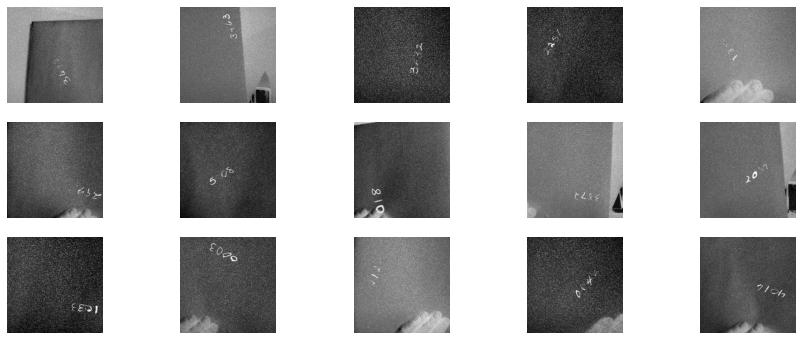

In [19]:
dbug.Debug.show_images_list(xs_test[:15].reshape(-1,pic_h,pic_w), col_number = 5)

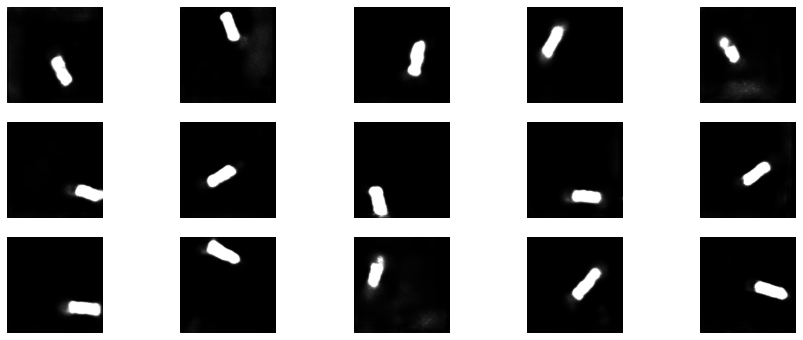

In [18]:
dbug.Debug.show_images_list(y_pred[:15].reshape(-1,pic_h,pic_w), col_number = 5)

Before normalization Max: 227 Min: 57 Mean: 109.11476135253906 Std: 19.27457350910624
After normalization Max: 255 Min: 0 Mean: 78.18122863769531 Std: 28.90958768406625
Before normalization Max: 229 Min: 6 Mean: 94.50497436523438 Std: 38.25198745617654
After normalization Max: 255 Min: 0 Mean: 101.15545654296875 Std: 43.77945998372265
Before normalization Max: 235 Min: 31 Mean: 106.56040954589844 Std: 26.200106286745562
After normalization Max: 255 Min: 0 Mean: 94.4493408203125 Std: 32.74885144999742
Before normalization Max: 221 Min: 30 Mean: 111.13973999023438 Std: 31.61071702354981
After normalization Max: 255 Min: 0 Mean: 108.26445007324219 Std: 42.256684773863974
Before normalization Max: 229 Min: 25 Mean: 113.38902282714844 Std: 29.481790609190227
After normalization Max: 255 Min: 0 Mean: 110.48045349121094 Std: 36.85942570357908
Before normalization Max: 215 Min: 27 Mean: 109.52059936523438 Std: 35.33448357101891
After normalization Max: 255 Min: 0 Mean: 111.93583679199219 Std: 

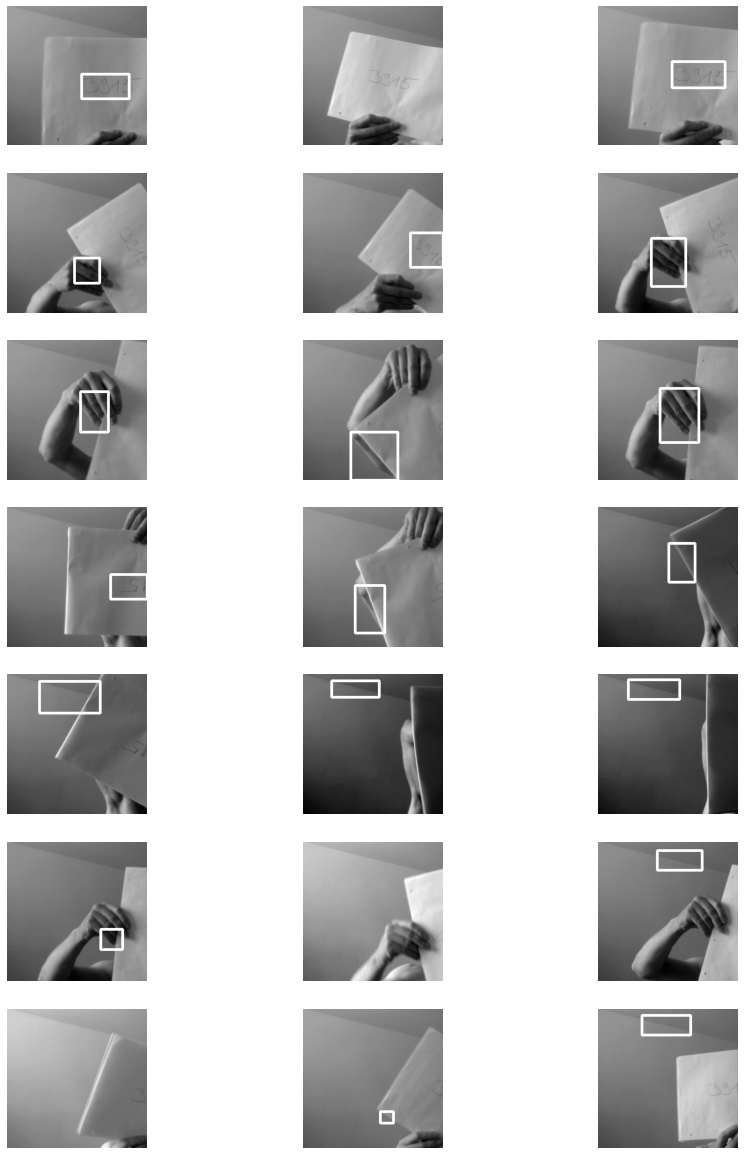

In [432]:
####Small test pipilene

import cv2 as cv
import importlib
importlib.reload(dgen)

###read images
test_images = dgen.Image_generator.load_from_folder("Data/4dig/test")
result_list = []

for img in test_images:
    ###read img
    #img_inp = cv.imread('Data/4dig/test/WIN_20200621_10_45_54_Pro.jpg', cv.IMREAD_UNCHANGED) 
    img_inp = img
    ###Cut image
    t,l,h,w = 0,120,(img_inp.shape[0]-70),(img_inp.shape[0]-70)
    img_inp = img_inp[t:t+h,l:l+w]
    ###Convert to gray and resize
    img_gray = cv.cvtColor(img_inp, cv.COLOR_BGR2GRAY)
    img_gray = cv.resize(img_gray, (256,256), interpolation = cv.INTER_AREA) 
    ###Get inversion
    img_gray_inv = (255-img_gray)
    #Normalise image
    mean, STD  = cv.meanStdDev(img_gray_inv)
    offset_pos = 3
    offset_neg = 3
    #img_gray = np.clip(img_gray_inv, mean - offset_neg*STD, mean + offset_pos*STD) 
    print("Before normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    img_gray_inv = cv.normalize(img_gray_inv, img_gray_inv, 0, 255, norm_type=cv.NORM_MINMAX)
    print("After normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    ###Show prepared image
    ###dbug.Debug.show_image(img[:,:,[2,1,0]]) #for PIL format
    #dbug.Debug.show_image(img_gray_inv.reshape(pic_h,pic_w))
    ###rescale for NN
    img_gray_inv_scaled  = scaler.transform(img_gray_inv.reshape(-1,256*256))
    ###Make prediction
    predict = model(img_gray_inv_scaled.reshape(-1,256,256,1)).numpy()
    predict_tresh = cv.threshold(predict.reshape(256,256), 0.5, 1, cv.THRESH_BINARY)[1].astype('uint8')
    ###Find contours
    contours, hierarchy = cv.findContours(predict_tresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    result = img_gray.reshape(256,256)
    bb_list = [cv.boundingRect(contour) for contour in contours]
    if(bb_list):
        bb = max(bb_list, key=lambda item: item[2])
        #result = cv.drawContours(result, contours[0], -1, 255, 3)
        result = cv.rectangle(result, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), 255, 4)
    result_list.append(result)
    
###Show result
dbug.Debug.show_images_list(result_list, col_number = 3, height=3)